In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from vlfpy import *
import random

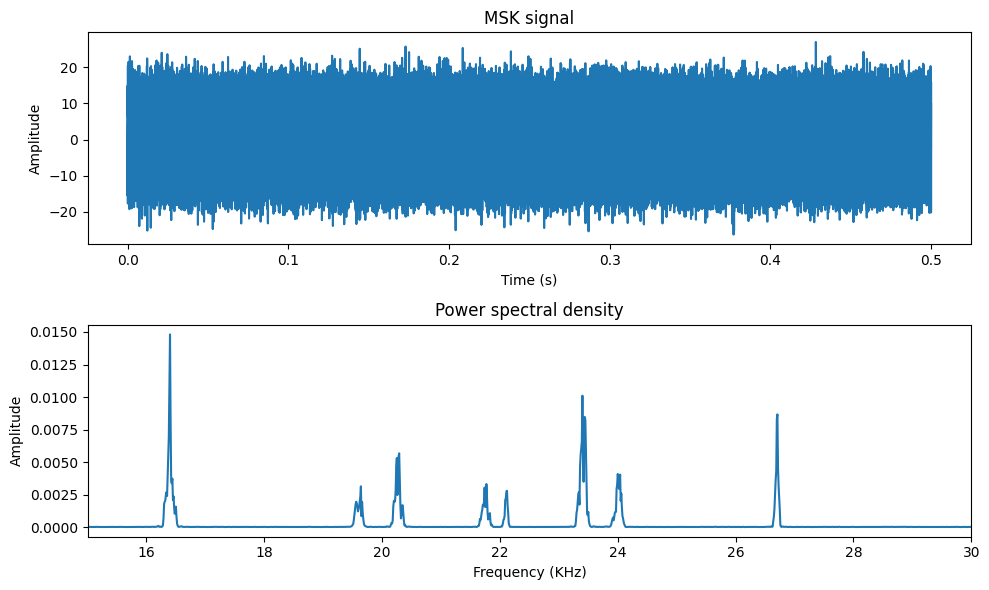

In [2]:
carriers = np.array([16.40e3, 19.60e3, 20.27e3, 21.75e3, 22.10e3, 23.40e3, 24.00e3, 26.70e3])
baudrate = np.array([200,     200,     200,     200,     100,     200,     200,     100])
T_symbols = 1/baudrate

fs = 4e6
time = 0.5 # seconds to simulate


t = np.linspace(0, time, int(fs*time)) # time vector

# store all parameters 
msk_data_single = np.zeros((len(carriers), len(t)))
msk_data = np.zeros_like(t)
offset = np.zeros_like(carriers)
phase_offset = np.zeros_like(carriers)
amplitude = np.zeros_like(carriers)
data_true = np.zeros((len(carriers),int(time/T_symbols[0])))
phase = np.zeros((len(carriers),len(t)))

# create data
for i, (carrier, T) in enumerate(zip(carriers, T_symbols)):    
    offset[i] = random.uniform(-T_symbols[i]/2, T_symbols[i]/2) # random timing offset
    phase_offset[i] = random.uniform(-np.pi, np.pi) # random phase offset
    amplitude[i] = random.uniform(0.5, 2) # random amplitude
    msk_data_single[i], _, data_temp, phase[i] = generate_msk(int(time/T), 0.5, T, carrier, fs, offset=offset[i], phase_offset=phase_offset[i], amplitude=amplitude[i]) # generate single MSK signal
    msk_data += msk_data_single[i]
    data_true[i,0:int(time/T)] = data_temp[0:int(time/T)] # store symbols, slised to account for different baudrates

msk_data += np.random.normal(0, 5, msk_data.shape) # add noise

# fft of the signal
f, fft_msk_data = signal.welch(msk_data, fs, nperseg=len(msk_data)/5)


fig, axs = plt.subplots(2, 1, figsize=(10, 6))

axs[0].plot(t, msk_data)
axs[0].set_ylabel('Amplitude')
axs[0].set_xlabel('Time (s)')
axs[0].set_title('MSK signal')


axs[1].plot(f/1e3, fft_msk_data)#10*np.log10(Pxx))
axs[1].set_ylabel('Amplitude')
axs[1].set_xlabel('Frequency (KHz)')
axs[1].set_title('Power spectral density')
axs[1].set_xlim(15, 30)
plt.tight_layout()

# add zeroes

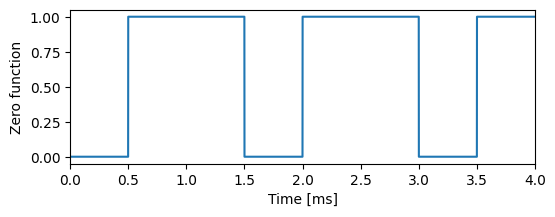

In [3]:
zeroes_test = np.ones_like(msk_data)
zeroes_test_inserted = add_zeros(zeroes_test, 0.0005, 0.0015, fs)

fig, axs = plt.subplots(figsize=(6, 2))
axs.plot(t/1e-3, zeroes_test_inserted)
axs.set_ylabel('Zero function')
axs.set_xlabel('Time [ms]')
axs.set_xlim(0, 4)

# msk_data_zeros = add_zeros(msk_data, 0.0005, 0.0015, fs) # add zeros to the signal
msk_data_zeros = msk_data

# downconvert to baseband

c:\Users\claes\miniconda3\Lib\site-packages\scipy\signal\_spectral_py.py:1870: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


Text(0.5, 0, 'Frequency [kHz]')

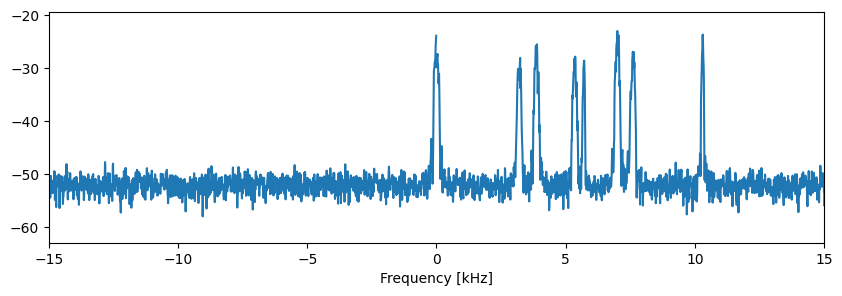

In [4]:
msk_data_down = np.zeros((len(carriers), len(t)), dtype=complex)
for i, (carrier, T) in enumerate(zip(carriers, T_symbols)):
    msk_data_down[i] = msk_data_zeros*np.exp(-1j*2*np.pi*carrier*t) # downconvert the signal to separate carrier basebands


# fft of the baseband signals
f, fft_msk_data_down = signal.welch(msk_data_down, fs, nperseg=len(msk_data_down[0])/5)
fft_msk_data_down[:,len(fft_msk_data_down[0])//2] = np.nan # removes line between positive and negative frequencies

index = 0  # select the carrier to plot

fig, axs = plt.subplots(figsize=(10, 3))

axs.plot(f/1e3, 10*np.log10(fft_msk_data_down[index]))
axs.set_xlim(-15,15)
axs.set_xlabel('Frequency [kHz]')

# lowpass filter

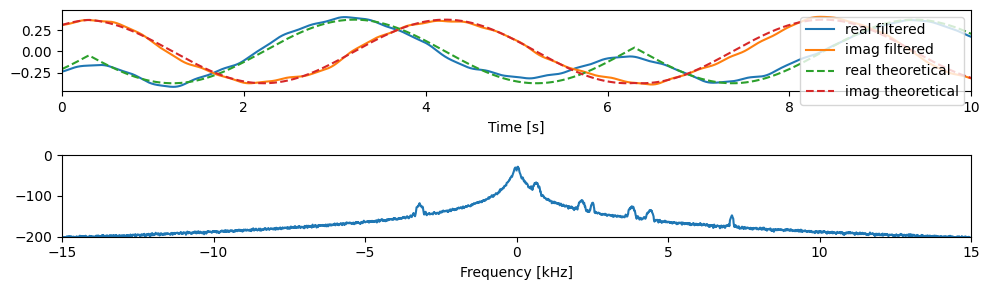

In [5]:
msk_data_down_filtered = np.zeros_like(msk_data_down)
for i in range(len(carriers)):
    sos = signal.butter(2,1/T_symbols[i], 'low', output='sos', fs=fs) # 1/T_symbols[0]/2 removes more noise, but also some of the signal 
    temp = np.append(np.ones(int(fs*T_symbols[i]))*np.mean(msk_data_down[i,0:int(fs*T_symbols[i])]), msk_data_down[i]) # pre append the mean value to avoid filter transient
    msk_data_down_filtered[i] = signal.sosfiltfilt(sos, temp)[int(fs*T_symbols[i]):] # filter the signal, remove the pre appended mean value

# fft of the filtered baseband signals
f, fft_msk_data_down_filtered = signal.welch(msk_data_down_filtered, fs, nperseg=len(msk_data_down_filtered[0])/5)
fft_msk_data_down_filtered[:,len(fft_msk_data_down_filtered[0])//2] = np.nan # removes line between positive and negative frequencies

index = 1  # select the carrier to plot

fig, axs = plt.subplots(2,1, figsize=(10, 3))

axs[0].plot(t/T_symbols[index], msk_data_down_filtered[index].real, label='real filtered')
axs[0].plot(t/T_symbols[index], msk_data_down_filtered[index].imag, label='imag filtered')
axs[0].plot(t/T_symbols[index], 1/2*amplitude[index]*np.exp(1j*(phase[index] - 2*np.pi*carriers[index]*offset[index] + phase_offset[index])).real, label='real theoretical', ls='--')
axs[0].plot(t/T_symbols[index], 1/2*amplitude[index]*np.exp(1j*(phase[index] - 2*np.pi*carriers[index]*offset[index] + phase_offset[index])).imag, label='imag theoretical', ls='--')
axs[0].set_xlim(0, 10)
axs[0].legend(loc='upper right')
axs[0].set_xlabel('Time [s]')

axs[1].plot(f/1e3, 10*np.log10(fft_msk_data_down_filtered[index]))
axs[1].set_xlim(-15,15)
axs[1].set_ylim(-200, 0)
axs[1].set_xlabel('Frequency [kHz]')
plt.tight_layout()




# Paramter estimation 
## Amplitude

In [6]:
a_hat = np.zeros(len(carriers))

for i in range(len(carriers)):
    a_hat[i] = amplitude_estimation(msk_data_down_filtered[i, int(1*fs*T_symbols[i]):-int(1*fs*T_symbols[i])])

## Timing offset and phase offset

In [7]:
tau_hat = np.zeros_like(carriers)
theta_hat = np.zeros_like(carriers)

for i in range(len(carriers)):
    _, _, tau_hat[i], theta_hat[i] = phase_and_time_sync(msk_data_down_filtered[i], int(fs*T_symbols[i]),  T_symbols[i], fs,int(time/T))

    if tau_hat[i] < 0 :
        theta_hat[i] += 0.5*np.pi  # this is not correct but it gives good results
    
    
    theta_hat[i] = (theta_hat[i] + 2*np.pi*carriers[i]*tau_hat[i]) % (np.pi) - 0.5*np.pi # correct the phase offset to account of donwconversion offset

# Parameter correction

a better solution would be to remove the first and last uncomplete symbols instead of using the roll function 

In [8]:
msk_corrected = np.zeros_like(msk_data_down_filtered)
for i in range(len(carriers)):
    msk_corrected[i] = np.roll(msk_data_down_filtered[i]*np.exp(1j*(theta_hat[i])),-int(tau_hat[i]*fs))

# Viterbi decoder

In [9]:
decoded_bits = np.zeros((len(carriers), int(time/T_symbols[0])))
for i in range(len(carriers)):
    decoded_bits[i,0:int(time/T_symbols[i])], _ = viterbi_decoder(msk_corrected[i], int(T_symbols[i]*fs))[0:int(time/T_symbols[i])]

# Performance evaluation

In [10]:
for i in range(len(carriers)):
    print(f'Carrier {i+1}:')
    print(f'Offset: {np.round(offset[i],6)} Offset estimated: {np.round(tau_hat[i],6)} error: {np.abs(offset[i]-tau_hat[i]):.6f}')
    print(f'Phase offset: {np.round(phase_offset[i]/np.pi,4)} Phase offset estimated: {np.round(theta_hat[i]/np.pi,4)}')
    print(f'Amplitude: {np.round(amplitude[i],4)} Amplitude estimated: {np.round(a_hat[i],4)} error: {np.round(np.abs(amplitude[i]-a_hat[i]),4)}')
    print(f'Number of errors: {np.sum(decoded_bits[i] != data_true[i])}')
    print(f'Error rate: {np.sum(decoded_bits[i] != data_true[i])/len(data_true[i])} \n')
 

Carrier 1:
Offset: 0.001846 Offset estimated: 0.001835 error: 0.000011
Phase offset: -0.3925 Phase offset estimated: -0.2438
Amplitude: 1.3143 Amplitude estimated: 1.3022 error: 0.0121
Number of errors: 0
Error rate: 0.0 

Carrier 2:
Offset: 0.001477 Offset estimated: 0.001459 error: 0.000018
Phase offset: -0.0481 Phase offset estimated: -0.2576
Amplitude: 0.7482 Amplitude estimated: 0.7375 error: 0.0107
Number of errors: 1
Error rate: 0.01 

Carrier 3:
Offset: -0.000909 Offset estimated: -0.000908 error: 0.000000
Phase offset: -0.2504 Phase offset estimated: 0.2728
Amplitude: 1.0124 Amplitude estimated: 1.0036 error: 0.0088
Number of errors: 1
Error rate: 0.01 

Carrier 4:
Offset: -0.000797 Offset estimated: -0.000815 error: 0.000018
Phase offset: -0.1972 Phase offset estimated: 0.0151
Amplitude: 0.734 Amplitude estimated: 0.7337 error: 0.0003
Number of errors: 0
Error rate: 0.0 

Carrier 5:
Offset: 0.004748 Offset estimated: 0.004711 error: 0.000037
Phase offset: -0.101 Phase offset 

In [11]:
index = 2  # select the carrier to examine
print(decoded_bits[index])
print(data_true[index])

[1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0.
 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1.
 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0.
 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.
 0. 0. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0.
 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1.
 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0.
 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.
 0. 0. 1. 1.]


# Create replicates and subtract them from the received signal

In [12]:
# correct the phase offset by pi where nessesary. can be seen by examinng the filtered spectrum
theta_hat[2] -= np.pi
theta_hat[3] -= np.pi
theta_hat[4] -= np.pi
theta_hat[7] -= np.pi

In [13]:
msk_clean = np.copy(msk_data)

for i in range(len(carriers)):
    temp, _, _ = generate_msk_data(decoded_bits[i,0:int(time/T_symbols[i])], T_symbols[i], carriers[i], fs, offset=tau_hat[i], phase_offset=theta_hat[i], amplitude=a_hat[i])
    msk_clean += -temp

# Examine the result

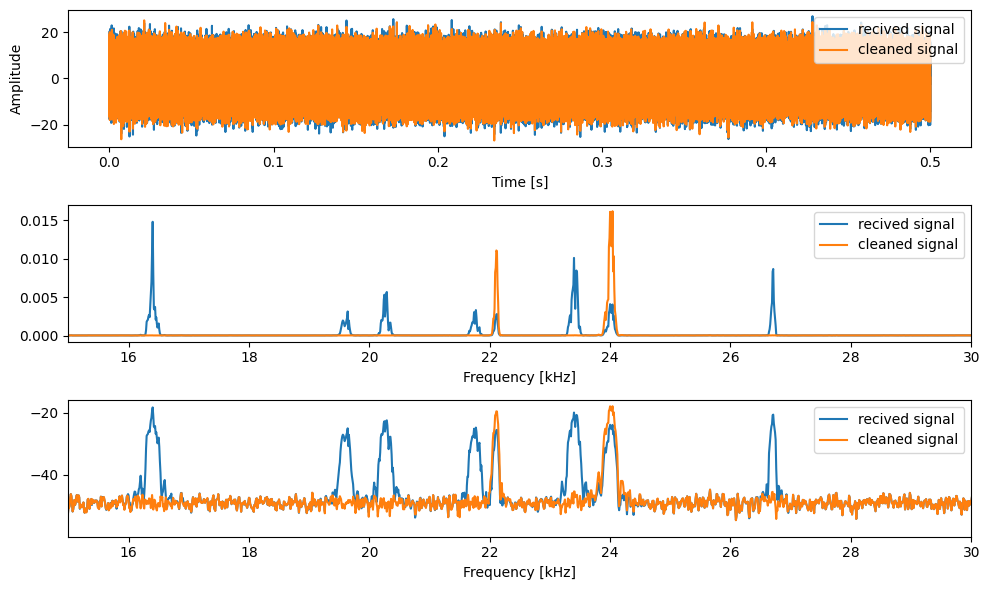

In [14]:
f, fft_msk_clean = signal.welch(msk_clean, fs, nperseg=len(msk_clean)/5)

fig, axs = plt.subplots(3,1, figsize=(10, 6))

axs[0].plot(t, msk_data, label='recived signal')
axs[0].plot(t, msk_clean, label='cleaned signal') # this plot is best without gaussian noise added
axs[0].set_ylabel('Amplitude')
axs[0].set_xlabel('Time [s]')
axs[0].legend(loc='upper right')

axs[1].plot(f/1e3, fft_msk_data, label='recived signal')
axs[1].plot(f/1e3, fft_msk_clean, label='cleaned signal')
axs[1].set_xlabel('Frequency [kHz]')
axs[1].set_xlim(15, 30)
axs[1].legend(loc='upper right')

axs[2].plot(f/1e3, 10*np.log10(fft_msk_data), label='recived signal')
axs[2].plot(f/1e3, 10*np.log10(fft_msk_clean), label='cleaned signal')
axs[2].set_xlabel('Frequency [kHz]')
axs[2].set_xlim(15, 30)
axs[2].legend(loc='upper right')


plt.tight_layout()

# Analyse a single signal and its replica

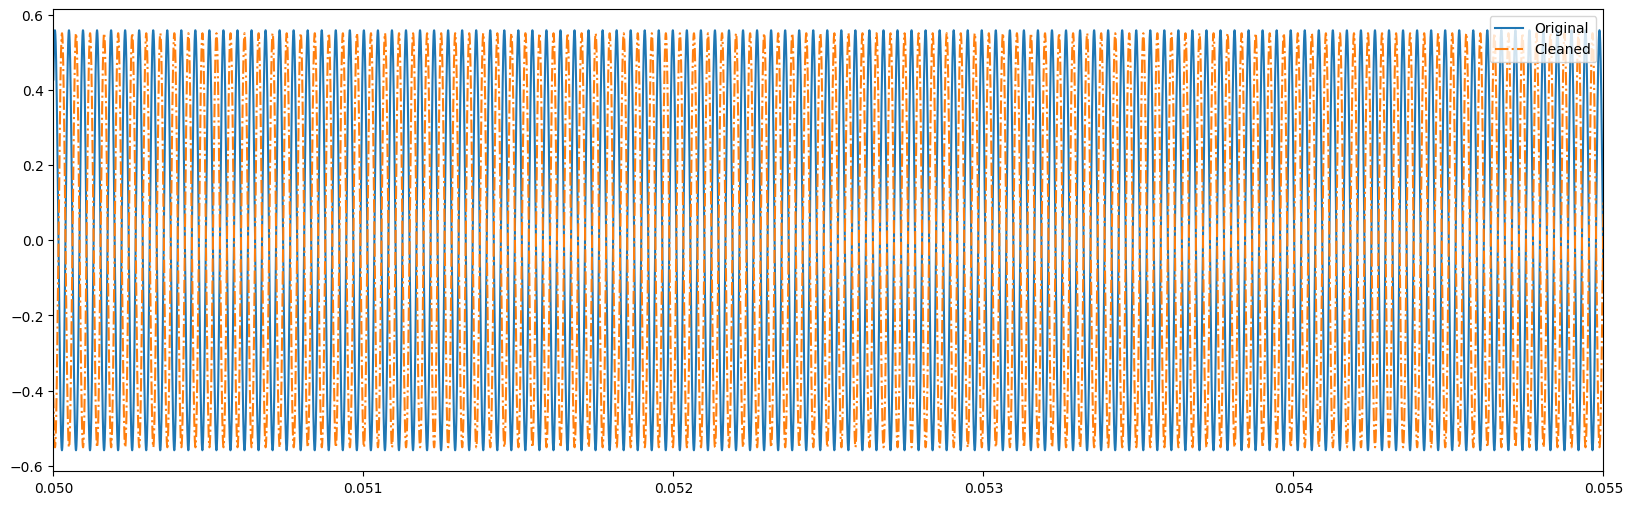

In [15]:
index = 4 # select the carrier to examine
s_replica, t, _ = generate_msk_data(decoded_bits[index,0:int(time/T_symbols[index])], T_symbols[index], carriers[index], fs, offset=tau_hat[index], phase_offset=theta_hat[index], amplitude=a_hat[index])
plt.figure(figsize=(20, 6))
plt.plot(t, msk_data_single[index], label='Original')
plt.plot(t, s_replica, ls='-.', label='Cleaned')
plt.xlim(1/200*10, 11*1/200) # plot only 10 symbols
plt.legend(loc='upper right')